# Experiment POC OBI
> Can we get better by training on our assumptions?

In [ ]:
# default_exp poc_online_bayesian_inference

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


Import modules and functions were are going to use.

In [ ]:
# exports

import dataclasses
import traceback
from dataclasses import dataclass
from typing import Type, Union

import torch
import torch.utils.data
from blackhc.project import is_run_from_ipython
from blackhc.project.experiment import embedded_experiments
from torch.utils.data import Dataset

import batchbald_redux.acquisition_functions as acquisition_functions
import wandb
from batchbald_redux.acquisition_functions import (
    CandidateBatchComputer,
    EvalModelBatchComputer,
)
from batchbald_redux.active_learning import ActiveLearningData, RandomFixedLengthSampler
from batchbald_redux.black_box_model_training import evaluate_old, train
from batchbald_redux.dataset_challenges import (
    AdditiveGaussianNoise,
    NamedDataset,
    create_repeated_MNIST_dataset,
    get_balanced_sample_indices,
    get_base_dataset_index,
    get_target,
)
from batchbald_redux.di import DependencyInjection
from batchbald_redux.experiment_logging import asclassdict, init_wandb, log2wandb
from batchbald_redux.fast_mnist import FastMNIST
from batchbald_redux.model_optimizer_factory import ModelOptimizerFactory
from batchbald_redux.models import MnistOptimizerFactory
from batchbald_redux.online_bayesian_inference import evaluate_online_bayesian_inference

In [ ]:
# exports

# From the BatchBALD Repo
from batchbald_redux.train_eval_model import (
    TrainEvalModel,
    TrainSelfDistillationEvalModel,
)
from batchbald_redux.trained_model import TrainedBayesianModel

In [ ]:
# exports

from blackhc.progress_bar import create_progress_bar
from toma import toma


def compute_entropy_from_probs(probs_N_K_C: torch.Tensor) -> torch.Tensor:
    N, K, C = probs_N_K_C.shape

    entropies_N = torch.empty(N, dtype=torch.double)

    pbar = create_progress_bar(N, tqdm_args=dict(desc="Entropy", leave=False))
    pbar.start()

    @toma.execute.chunked(probs_N_K_C, 1024)
    def compute(probs_n_K_C, start: int, end: int):
        mean_probs_n_C = probs_n_K_C.mean(dim=1)
        nats_n_C = mean_probs_n_C * torch.log(mean_probs_n_C)
        nats_n_C[mean_probs_n_C == 0] = 0.0

        entropies_N[start:end].copy_(-torch.sum(nats_n_C, dim=1))
        pbar.update(end - start)

    pbar.finish()

    return entropies_N

In [ ]:
train_predictions = torch.load("./data/mnist_train_predictions.pt", map_location="cpu")
train_entropies = compute_entropy_from_probs(train_predictions[:, None, :])

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
from matplotlib import pyplot as plt

(array([55951.,  1227.,   635.,   386.,   241.,   206.,   130.,   117.,
          118.,    74.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <BarContainer object of 10 artists>)

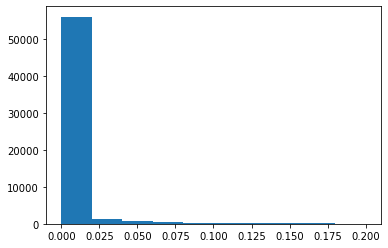

In [ ]:
plt.hist(train_entropies.cpu().numpy(), range=[0, 0.2])

In [ ]:
60000 - len(torch.nonzero(train_entropies < 0.01, as_tuple=True)[0].numpy())

5678

In [ ]:
# exports

# Rerun from 2022/04/15

training_set_90 = [
    46377,
    44390,
    7485,
    25450,
    12220,
    43112,
    3612,
    54256,
    44467,
    17555,
    4218,
    45101,
    41296,
    32261,
    3281,
    6944,
    7701,
    30692,
    24891,
    24436,
    17776,
    36852,
    26891,
    17001,
    44414,
    23050,
    30884,
    41516,
    8897,
    34608,
    11721,
    13127,
    9870,
    39700,
    13985,
    9608,
    17808,
    23028,
    3494,
    10210,
    42384,
    31742,
    17100,
    46530,
    26733,
    4762,
    14113,
    20798,
    28388,
    42973,
    37347,
    55042,
    41295,
    28310,
    19280,
    18501,
    274,
    11208,
    13335,
    24440,
    49493,
    58129,
    56210,
    40766,
    13318,
    50040,
    18408,
    7255,
    15494,
    7168,
    9472,
    14845,
    14096,
    26072,
    35944,
    34836,
    12655,
    991,
    38577,
    47322,
    45212,
    16286,
    5308,
    38182,
    31624,
    12702,
    30861,
    46320,
    36408,
    49841,
    33426,
    57527,
    3273,
    24740,
    39627,
    22199,
    19362,
    42136,
    41965,
    43095,
]

training_set_90[:20] = [
    51348,
    49110,
    8222,
    28130,
    13484,
    47685,
    3938,
    59930,
    49196,
    19427,
    4601,
    49922,
    45635,
    35684,
    3579,
    7621,
    8465,
    33959,
    27521,
    27015,
]


@dataclass
class Experiment:
    seed: int = 1337
    num_pool_samples: int = 20
    num_validation_samples: int = 20
    num_training_samples: int = 1
    num_patience_epochs: int = 5 * 4
    max_training_epochs: int = 30 * 4
    training_batch_size: int = 64
    device: str = "cuda"
    validation_set_size: int = 1024
    min_samples_per_epoch: int = 1024
    model_optimizer_factory: Type[ModelOptimizerFactory] = MnistOptimizerFactory
    max_obi_steps: int = 10
    num_samples_list: int = (100, 1000, 10000)
    up_factor: int = 2
    num_trials: int = 5
    acquisition_size: int = 5

    def load_dataset(self) -> (ActiveLearningData, Dataset, Dataset):
        train_dataset = NamedDataset(
            FastMNIST("data", train=True, download=True, device=self.device), "FastMNIST (train)"
        )

        active_learning_data = ActiveLearningData(train_dataset)

        active_learning_data.acquire_base_indices(training_set_90[:20])

        active_learning_data_validation_set = ActiveLearningData(train_dataset)
        active_learning_data_validation_set.acquire_base_indices(training_set_90)

        validation_dataset = active_learning_data_validation_set.extract_dataset_from_pool(self.validation_set_size)
        validation_dataset = NamedDataset(
            validation_dataset, f"FastMNIST (validation, {len(validation_dataset)} samples)"
        )

        test_dataset = FastMNIST("data", train=False, device=self.device)
        test_dataset = NamedDataset(test_dataset, f"FastMNIST (test, {len(test_dataset)} samples)")

        return active_learning_data, validation_dataset, test_dataset, training_set_90[:20]

    # Simple Dependency Injection
    def create_train_eval_model(self, runtime_config) -> TrainEvalModel:
        config = {**vars(self), **runtime_config}
        di = DependencyInjection(config, [])
        return di.create_dataclass_type(self.train_eval_model)

    def run(self, store):
        init_wandb(self)

        torch.manual_seed(self.seed)

        # Active Learning setup
        active_learning_data, validation_dataset, test_dataset, initial_training_set_indices = self.load_dataset()
        store["initial_training_set_indices"] = initial_training_set_indices
        store["dataset_info"] = dict(training=repr(active_learning_data.base_dataset), test=repr(test_dataset))

        print(wandb.config)

        wandb.config.initial_training_set_indices = initial_training_set_indices
        wandb.config["dataset_info"] = store["dataset_info"]

        # initial_training_set_indices = active_learning_data.get_random_pool_indices(self.initial_set_size)
        # initial_training_set_indices = get_balanced_sample_indices(
        #     active_learning_data.pool_dataset, 10, self.initial_set_size // 10
        # )

        train_loader = torch.utils.data.DataLoader(
            active_learning_data.training_dataset,
            batch_size=self.training_batch_size,
            sampler=RandomFixedLengthSampler(active_learning_data.training_dataset, self.min_samples_per_epoch),
            drop_last=True,
        )

        validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, drop_last=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, drop_last=False)

        store["obi_performances"] = []
        obi_performances = store["obi_performances"]
        
        store["upperbound_performances"] = []
        upperbound_performances = store["upperbound_performances"]

        store["active_learning_steps"] = []
        active_learning_steps = store["active_learning_steps"]

        # Active Training Loop
        while True:
            training_set_size = len(active_learning_data.training_dataset)
            print(f"Training set size {training_set_size}:")

            # iteration_log = dict(training={}, pool_training={}, evaluation_metrics=None, acquisition=None)
            active_learning_steps.append({})
            iteration_log = active_learning_steps[-1]

            iteration_log["training"] = {}

            model_optimizer = self.model_optimizer_factory().create_model_optimizer()

            if training_set_size > 0:
                train(
                    model=model_optimizer.model,
                    optimizer=model_optimizer.optimizer,
                    training_samples=self.num_training_samples,
                    validation_samples=self.num_validation_samples,
                    train_loader=train_loader,
                    validation_loader=validation_loader,
                    patience=self.num_patience_epochs,
                    max_epochs=self.max_training_epochs,
                    device=self.device,
                    training_log=iteration_log["training"],
                    wandb_key_path="model_training",
                )

            evaluation_metrics = evaluate_old(
                model=model_optimizer.model,
                num_samples=self.num_validation_samples,
                loader=test_loader,
                device=self.device,
            )
            iteration_log["evaluation_metrics"] = evaluation_metrics
            log2wandb(evaluation_metrics, commit=False)
            print(f"Perf after training {evaluation_metrics}")
            
            obi_results, upperbound_result = evaluate_online_bayesian_inference(
                model=model_optimizer.model,
                real_training_set_size=training_set_size,
                train_dataset=active_learning_data.base_dataset,
                test_dataset=test_dataset,
                training_indices=training_set_90[: training_set_size + self.max_obi_steps],
                start_index=training_set_size,
                num_samples_list=self.num_samples_list,
                num_trials=self.num_trials,
                up_factor=self.up_factor,
                eval_batchsize=512,
                device=self.device,
            )

            obi_performances.append(obi_results)
            upperbound_performances.append(upperbound_result)
            log2wandb(
                dict(
                    obi_performances=[asclassdict(result) for result in obi_results],
                    upperbound_performance=asclassdict(upperbound_result),
                ),
                commit=False,
            )

            if training_set_size >= len(training_set_90):
                log2wandb({}, commit=True)
                print("Done.")
                break

            next_indices = training_set_90[training_set_size : training_set_size + self.acquisition_size]
            iteration_log["acquisition"] = dict(indices=next_indices)

            active_learning_data.acquire_base_indices(next_indices)
            log2wandb({}, commit=True)

In [ ]:
# experiment

experiment = Experiment(seed=1120, num_pool_samples=100, device="cuda", num_samples_list=(10, 100))

results = {}
experiment.run(results)

accuracy,▁
crossentropy,▁
model_training/best_epoch,▁
model_training/best_val_accuracy,▁
model_training/best_val_crossentropy,▁
accuracy,0.5996
crossentropy,1.77773
model_training/best_epoch,29
model_training/best_val_accuracy,0.60156
model_training/best_val_crossentropy,1.88428


{'Dataclass': '__main__.Experiment', 'seed': 1120, 'num_pool_samples': 100, 'num_validation_samples': 20, 'num_training_samples': 1, 'num_patience_epochs': 20, 'max_training_epochs': 120, 'training_batch_size': 64, 'device': 'cuda', 'validation_set_size': 1024, 'min_samples_per_epoch': 1024, 'model_optimizer_factory': 'batchbald_redux.models.MnistOptimizerFactory', 'max_obi_steps': 10, 'num_samples_list': [10, 100], 'up_factor': 2, 'num_trials': 5, 'acquisition_size': 5}
Training set size 20:


  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.498046875, 'crossentropy': 1.698270320892334}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5869140625, 'crossentropy': 1.4432613849639893}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.56640625, 'crossentropy': 1.6315778493881226}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.57421875, 'crossentropy': 1.6933497190475464}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.578125, 'crossentropy': 1.6983140707015991}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5546875, 'crossentropy': 1.8744792938232422}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5849609375, 'crossentropy': 1.8153116703033447}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.578125, 'crossentropy': 1.8306891918182373}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.556640625, 'crossentropy': 1.8482317924499512}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.576171875, 'crossentropy': 1.8684550523757935}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5751953125, 'crossentropy': 1.806377649307251}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.583984375, 'crossentropy': 1.808190107345581}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.580078125, 'crossentropy': 1.8413379192352295}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5830078125, 'crossentropy': 1.8899109363555908}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.583984375, 'crossentropy': 1.876299500465393}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5615234375, 'crossentropy': 1.9736772775650024}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5625, 'crossentropy': 2.066951036453247}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5908203125, 'crossentropy': 1.8146048784255981}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.580078125, 'crossentropy': 1.9622409343719482}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5859375, 'crossentropy': 2.011101245880127}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.552734375, 'crossentropy': 2.0409812927246094}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.568359375, 'crossentropy': 2.0042529106140137}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5849609375, 'crossentropy': 1.9034472703933716}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.578125, 'crossentropy': 1.784635305404663}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.568359375, 'crossentropy': 1.7980711460113525}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5908203125, 'crossentropy': 1.768648624420166}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.583984375, 'crossentropy': 1.8436307907104492}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5712890625, 'crossentropy': 2.0871682167053223}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.58984375, 'crossentropy': 1.9061651229858398}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.59375, 'crossentropy': 1.893503189086914}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5859375, 'crossentropy': 2.025881290435791}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5888671875, 'crossentropy': 1.97034752368927}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5888671875, 'crossentropy': 1.9118006229400635}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5908203125, 'crossentropy': 2.0066781044006348}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.59765625, 'crossentropy': 1.9450751543045044}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.58203125, 'crossentropy': 2.005213737487793}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5810546875, 'crossentropy': 1.9534133672714233}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.568359375, 'crossentropy': 1.9242274761199951}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.57421875, 'crossentropy': 2.085645914077759}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.583984375, 'crossentropy': 2.064002752304077}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.572265625, 'crossentropy': 2.073512315750122}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5791015625, 'crossentropy': 2.0619754791259766}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5859375, 'crossentropy': 1.8491023778915405}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.580078125, 'crossentropy': 1.9167743921279907}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5693359375, 'crossentropy': 2.020437717437744}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.55859375, 'crossentropy': 1.8997365236282349}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.57421875, 'crossentropy': 1.9237723350524902}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5888671875, 'crossentropy': 1.9672794342041016}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5703125, 'crossentropy': 2.088172435760498}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.58203125, 'crossentropy': 1.8703957796096802}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5791015625, 'crossentropy': 1.9217575788497925}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5771484375, 'crossentropy': 2.0212905406951904}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5927734375, 'crossentropy': 1.9173277616500854}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5927734375, 'crossentropy': 1.9478100538253784}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5869140625, 'crossentropy': 1.967516303062439}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.59765625)
RestoringEarlyStopping: Restoring optimizer.
{'model_training/val_metrics': <wandb.data_types.Table object at 0x7feeb4d06220>, 'model_training/best_epoch': 34, 'model_training/best_val_accuracy': 0.59765625, 'model_training/best_val_crossentropy': 1.9450751543045044}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.597, 'crossentropy': 1.830930859375, '_timestamp': 1650399242, '_runtime': 28}


get_predictions_labels:   0%|          | 0/2006000 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 20/10/0
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=20, trial_index=0, num_samples=10, accuracy=0.5910999774932861, crossentropy=2.2180018424987793)
Online Training Size/Num Samples/Trial: 20/10/1
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=20, trial_index=1, num_samples=10, accuracy=0.5827000141143799, crossentropy=2.0835869312286377)
Online Training Size/Num Samples/Trial: 20/10/2
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=20, trial_index=2, num_samples=10, accuracy=0.5903000235557556, crossentropy=1.8148714303970337)
Online Training Size/Num Samples/Trial: 20/10/3
OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=20, trial_index=3, num_samples=10, accuracy=0.5856000185012817, crossentropy=1.9677722454071045)
Online Training Size/Num Samples/Trial: 

  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.44921875, 'crossentropy': 1.856518030166626}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.630859375, 'crossentropy': 1.2549703121185303}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.640625, 'crossentropy': 1.1209205389022827}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.671875, 'crossentropy': 1.0541449785232544}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6796875, 'crossentropy': 1.0794131755828857}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6943359375, 'crossentropy': 1.0215439796447754}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6982421875, 'crossentropy': 1.0682412385940552}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69140625, 'crossentropy': 1.1076823472976685}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69140625, 'crossentropy': 1.0712047815322876}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6953125, 'crossentropy': 1.1108332872390747}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6806640625, 'crossentropy': 1.1535918712615967}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.666015625, 'crossentropy': 1.1108342409133911}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6962890625, 'crossentropy': 1.055483341217041}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6796875, 'crossentropy': 1.0697667598724365}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6748046875, 'crossentropy': 1.1307344436645508}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.681640625, 'crossentropy': 1.0840954780578613}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.701171875, 'crossentropy': 1.0406358242034912}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.697265625, 'crossentropy': 1.0697234869003296}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69921875, 'crossentropy': 1.058584213256836}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.703125, 'crossentropy': 1.0953316688537598}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.685546875, 'crossentropy': 1.1081825494766235}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6748046875, 'crossentropy': 1.186870813369751}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6669921875, 'crossentropy': 1.1322853565216064}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6962890625, 'crossentropy': 1.0614471435546875}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.70703125, 'crossentropy': 1.0820726156234741}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.703125, 'crossentropy': 1.0782809257507324}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.703125, 'crossentropy': 1.1027195453643799}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.685546875, 'crossentropy': 1.1368708610534668}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6923828125, 'crossentropy': 1.140493631362915}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.693359375, 'crossentropy': 1.1100842952728271}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6904296875, 'crossentropy': 1.133840799331665}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6904296875, 'crossentropy': 1.131980538368225}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69140625, 'crossentropy': 1.1707013845443726}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.689453125, 'crossentropy': 1.1046849489212036}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6953125, 'crossentropy': 1.1158068180084229}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.693359375, 'crossentropy': 1.1580835580825806}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6962890625, 'crossentropy': 1.1171997785568237}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6962890625, 'crossentropy': 1.1185073852539062}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6943359375, 'crossentropy': 1.1397669315338135}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.66796875, 'crossentropy': 1.2217668294906616}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6845703125, 'crossentropy': 1.122391700744629}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6748046875, 'crossentropy': 1.1272904872894287}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.68359375, 'crossentropy': 1.1383116245269775}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.66015625, 'crossentropy': 1.1926709413528442}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.681640625, 'crossentropy': 1.1588342189788818}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.70703125)
RestoringEarlyStopping: Restoring optimizer.
{'model_training/val_metrics': <wandb.data_types.Table object at 0x7feeb4cca670>, 'model_training/best_epoch': 24, 'model_training/best_val_accuracy': 0.70703125, 'model_training/best_val_crossentropy': 1.0820726156234741}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.717, 'crossentropy': 1.01125322265625, '_timestamp': 1650399275, '_runtime': 61}


get_predictions_labels:   0%|          | 0/2007000 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 25/10/0
OBIPerformance(total_training_set_size=25, real_training_set_size=25, online_training_set_size=25, trial_index=0, num_samples=10, accuracy=0.71670001745224, crossentropy=1.0214773416519165)
Online Training Size/Num Samples/Trial: 25/10/1
OBIPerformance(total_training_set_size=25, real_training_set_size=25, online_training_set_size=25, trial_index=1, num_samples=10, accuracy=0.723800003528595, crossentropy=0.9048498868942261)
Online Training Size/Num Samples/Trial: 25/10/2
OBIPerformance(total_training_set_size=25, real_training_set_size=25, online_training_set_size=25, trial_index=2, num_samples=10, accuracy=0.7107999920845032, crossentropy=1.0695911645889282)
Online Training Size/Num Samples/Trial: 25/10/3
OBIPerformance(total_training_set_size=25, real_training_set_size=25, online_training_set_size=25, trial_index=3, num_samples=10, accuracy=0.7063000202178955, crossentropy=1.1058127880096436)
Online Training Size/Num Samples/Trial: 25/

  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.4755859375, 'crossentropy': 1.9365075826644897}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.5859375, 'crossentropy': 1.2988812923431396}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6552734375, 'crossentropy': 1.0720024108886719}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6630859375, 'crossentropy': 1.0527043342590332}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6923828125, 'crossentropy': 0.9618135690689087}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6630859375, 'crossentropy': 1.0060240030288696}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.685546875, 'crossentropy': 1.0346741676330566}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.67578125, 'crossentropy': 0.994245171546936}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.689453125, 'crossentropy': 0.9833250641822815}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.689453125, 'crossentropy': 0.9997125267982483}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7021484375, 'crossentropy': 0.9695551991462708}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7021484375, 'crossentropy': 0.9893882274627686}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.705078125, 'crossentropy': 0.9860646724700928}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.671875, 'crossentropy': 1.1450977325439453}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6982421875, 'crossentropy': 1.016077995300293}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6982421875, 'crossentropy': 0.9775023460388184}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.701171875, 'crossentropy': 0.9959571361541748}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6943359375, 'crossentropy': 1.0017292499542236}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.716796875, 'crossentropy': 0.933784544467926}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7119140625, 'crossentropy': 0.9659706354141235}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6767578125, 'crossentropy': 1.0842918157577515}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7001953125, 'crossentropy': 0.9882994294166565}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.689453125, 'crossentropy': 1.0312467813491821}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69140625, 'crossentropy': 0.9937529563903809}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7080078125, 'crossentropy': 0.9977726340293884}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.693359375, 'crossentropy': 1.0168564319610596}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6796875, 'crossentropy': 1.0715240240097046}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6865234375, 'crossentropy': 1.068698525428772}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6982421875, 'crossentropy': 1.0681222677230835}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7080078125, 'crossentropy': 1.048799991607666}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.69921875, 'crossentropy': 1.0226521492004395}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6953125, 'crossentropy': 1.0766767263412476}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6884765625, 'crossentropy': 1.0700740814208984}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7060546875, 'crossentropy': 1.0074958801269531}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7197265625, 'crossentropy': 0.996133029460907}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.701171875, 'crossentropy': 1.0230679512023926}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.72265625, 'crossentropy': 0.961711585521698}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7177734375, 'crossentropy': 0.9780423641204834}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7099609375, 'crossentropy': 1.0045251846313477}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7138671875, 'crossentropy': 0.9967975616455078}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7177734375, 'crossentropy': 1.0070579051971436}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.71484375, 'crossentropy': 1.0135987997055054}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.720703125, 'crossentropy': 1.0104293823242188}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7216796875, 'crossentropy': 1.025801420211792}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7080078125, 'crossentropy': 1.0270580053329468}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7060546875, 'crossentropy': 1.0663819313049316}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.703125, 'crossentropy': 1.0449384450912476}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7060546875, 'crossentropy': 1.0056489706039429}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.697265625, 'crossentropy': 1.0358614921569824}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7080078125, 'crossentropy': 0.9749272465705872}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7255859375, 'crossentropy': 0.9382076859474182}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7255859375, 'crossentropy': 0.9409717321395874}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7138671875, 'crossentropy': 0.996443510055542}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.712890625, 'crossentropy': 1.015112280845642}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7197265625, 'crossentropy': 0.9762999415397644}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6923828125, 'crossentropy': 1.1398853063583374}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7177734375, 'crossentropy': 0.9939927458763123}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.73046875, 'crossentropy': 0.9550729393959045}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.73046875, 'crossentropy': 0.9536440968513489}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.70703125, 'crossentropy': 1.0097301006317139}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.689453125, 'crossentropy': 1.0761806964874268}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7109375, 'crossentropy': 1.0542153120040894}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7001953125, 'crossentropy': 1.0609701871871948}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6943359375, 'crossentropy': 1.0995185375213623}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7021484375, 'crossentropy': 1.0579948425292969}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.697265625, 'crossentropy': 1.0171080827713013}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.67578125, 'crossentropy': 1.1201931238174438}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6962890625, 'crossentropy': 1.0190379619598389}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6708984375, 'crossentropy': 1.142327070236206}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7197265625, 'crossentropy': 0.9680137634277344}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7177734375, 'crossentropy': 1.0113897323608398}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7197265625, 'crossentropy': 1.0133159160614014}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7216796875, 'crossentropy': 0.9995049238204956}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7021484375, 'crossentropy': 1.048302412033081}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7021484375, 'crossentropy': 1.0537757873535156}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6943359375, 'crossentropy': 1.0692312717437744}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.6748046875, 'crossentropy': 1.1178358793258667}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.71484375, 'crossentropy': 1.0029326677322388}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.73046875)
RestoringEarlyStopping: Restoring optimizer.
{'model_training/val_metrics': <wandb.data_types.Table object at 0x7fee808ce160>, 'model_training/best_epoch': 57, 'model_training/best_val_accuracy': 0.73046875, 'model_training/best_val_crossentropy': 0.9550729393959045}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.7503, 'crossentropy': 0.9040412109375, '_timestamp': 1650399318, '_runtime': 104}


get_predictions_labels:   0%|          | 0/2008000 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 30/10/0
OBIPerformance(total_training_set_size=30, real_training_set_size=30, online_training_set_size=30, trial_index=0, num_samples=10, accuracy=0.7264999747276306, crossentropy=0.9891496896743774)
Online Training Size/Num Samples/Trial: 30/10/1
OBIPerformance(total_training_set_size=30, real_training_set_size=30, online_training_set_size=30, trial_index=1, num_samples=10, accuracy=0.734000027179718, crossentropy=1.1417120695114136)
Online Training Size/Num Samples/Trial: 30/10/2
OBIPerformance(total_training_set_size=30, real_training_set_size=30, online_training_set_size=30, trial_index=2, num_samples=10, accuracy=0.7304999828338623, crossentropy=0.9575334191322327)
Online Training Size/Num Samples/Trial: 30/10/3
OBIPerformance(total_training_set_size=30, real_training_set_size=30, online_training_set_size=30, trial_index=3, num_samples=10, accuracy=0.7487999796867371, crossentropy=0.9357743263244629)
Online Training Size/Num Samples/Trial: 3

  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.3134765625, 'crossentropy': 2.0656332969665527}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.626953125, 'crossentropy': 1.3512336015701294}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7177734375, 'crossentropy': 0.9148144125938416}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.744140625, 'crossentropy': 0.7861782908439636}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.78125, 'crossentropy': 0.7199538350105286}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7705078125, 'crossentropy': 0.7569038271903992}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7734375, 'crossentropy': 0.7190671563148499}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7724609375, 'crossentropy': 0.7482227683067322}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7744140625, 'crossentropy': 0.7117286324501038}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.787109375, 'crossentropy': 0.7095447778701782}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.791015625, 'crossentropy': 0.6761534214019775}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8046875, 'crossentropy': 0.6823737621307373}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7939453125, 'crossentropy': 0.6939209699630737}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7900390625, 'crossentropy': 0.7028720378875732}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.78125, 'crossentropy': 0.7027364373207092}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7880859375, 'crossentropy': 0.68690025806427}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Engine run is terminating due to exception: 


Epoch metrics: {'accuracy': 0.7783203125, 'crossentropy': 0.7368150353431702}
RestoringEarlyStopping: 5 / 20


KeyboardInterrupt: 

In [ ]:
results

{'initial_training_set_indices': [51348,
  49110,
  8222,
  28130,
  13484,
  47685,
  3938,
  59930,
  49196,
  19427,
  4601,
  49922,
  45635,
  35684,
  3579,
  7621,
  8465,
  33959,
  27521,
  27015],
 'dataset_info': {'training': "'FastMNIST (train)'",
  'test': "'FastMNIST (test, 10000 samples)'"},
 'obi_performances': [[OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=0, num_samples=10, accuracy=0.538100004196167, crossentropy=1.516221893453387),
   OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=1, num_samples=10, accuracy=0.5690000057220459, crossentropy=1.394369463295061),
   OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_size=0, trial_index=2, num_samples=10, accuracy=0.578000009059906, crossentropy=1.4390312500523),
   OBIPerformance(total_training_set_size=20, real_training_set_size=20, online_training_set_s

In [ ]:
# exports

configs = [
    Experiment(
        seed=seed,
        acquisition_size=acquisition_size,
        num_pool_samples=num_pool_samples,
    )
    for seed in range(1)
    for acquisition_size in [5]
    for num_pool_samples in [100]
]

if not is_run_from_ipython() and __name__ == "__main__":
    for job_id, store in embedded_experiments(__file__, len(configs)):
        config = configs[job_id]
        config.seed += job_id
        print(config)
        store["config"] = dataclasses.asdict(config)
        store["log"] = {}

        try:
            config.run(store=store)
        except Exception:
            store["exception"] = traceback.format_exc()
            raise

In [ ]:
len(configs)

1

In [ ]:
# slow
import prettyprinter

prettyprinter.install_extras(include={"dataclasses"})

prettyprinter.pprint(configs)

[Experiment(seed=0, num_pool_samples=100)]



accuracy,▁▂▇█
crossentropy,▅█▃▁
model_training/best_epoch,▁▂▆█
model_training/best_val_accuracy,▁▂▆█
model_training/best_val_crossentropy,▅█▅▁
accuracy,0.7008
crossentropy,1.12005
model_training/best_epoch,46
model_training/best_val_accuracy,0.69922
model_training/best_val_crossentropy,1.07317
